# Задание №2. Деинтерлейсинг

## Описание

Задание разделено на 2 большие части:

### 1. Эвристический алгоритм

Реализовать эвристический алгоритм деинтерлейсинга, основанный на любых алгоритмах, расказанных (и не расказанных) на лекции.

**Требования**:
* работает не дольше 1 FPS
* использует _только_ те пакеты, которые указаны в файле `requirements.txt`

### 2. Нейросетевой алгоритм

Реализовать нейросетевой алгоритм деинтерлейсинга.

**Требования**:
* модель реализована на фреймворке TensorFlow / Keras
* обучение происходило _только_ на предоставленной обучающей выборке (но можно использовать разумное размножение выборки)

### Общие требования

* соблюдать [кодекс чести](https://communitystandards.stanford.edu/policies-and-guidance/honor-code). Виновные будут найдены и наказаны.

## Оценивание

1. Каждый участник может представить не более 1 эвристического алгоритма и не более 1 нейросетевого алгоритма для финального   тестирования

2. Тестирование будет проводиться на закрытой тестовой выборке, содержащей N (N < 10) тестовых видео

3. В качестве метрик будут использованы:
    * PSNR
    * SSIM
    
4. По итогам тестирования будет составлена общая таблица результатов по каждой из метрик

5. Место каждого алгоритма определяется по формуле: $Place_{algo} = \frac{Place_{PSNR} + Place_{SSIM}}{2}$

6. Баллы за конкретный алгоритм зависят от его места: $Score_{algo} = score(Place_{algo})$

7. Баллы участника складываются из баллов за эвристический алгоритм и нейросетевой алгоритм: $Score_{stud} = Score_{heuristic}^{stud} + Score_{neural}^{stud}$

8. Если какой-либо алгоритм не представлен студентом или не выполнены _требования_ — это эквивалентно обнулению соответствующего значения: $Score_{algo}^{stud} = 0$

## Повторение

* [Статья на Хабре](https://habr.com/en/post/51201/) про развёртки
* [Статья на Хабре](https://habr.com/en/post/61822/) про методы деинтерлейсинга

_Прогрессивная развёртка (построчная развёртка)_ — способ трансляции и хранения видео, при котором в каждом кадре все строки отображаются последовательно.

_Интерлейсинг (чересстрочная развёртка)_ — способ трансляции и хранения видео, при котором каждый кадр разбивается на два поля (чётное и нечётное).

<img src="extra/interlacing-scheme.gif" width="300"/>

* _Top Field (Odd Field, чётное поле)_ — чётные строки кадра
* _Bottom Field (Even Field, нечётное поле)_ — нечётные строки кадра

То, какое поле (чётное или нечётное) отвечает за более ранний момент времени — настраиваемый параметр. Обычно чётное поле по времени не позже нечётного

При интерлейсинге:
* частота кадров *увеличивается в 2 раза* относительно исходного видео в прогрессивной развёртке
* разрешение каждого отдельного кадра *уменьшается в 2 раза*

Это происходит из-за того, что в каждый момент времени на экране отображается только один полукадр.

![interlaced-vs-progressive](extra/interlaced-vs-progressive.jpg)

_Деинтерлейсинг_ — преобразование из чересстрочной развёртки в прогрессивную без потери частоты кадров.

## Часть 1. Эвристический деинтерлейсер

Скачайте тестовые данные отсюда: https://titan.gml-team.ru:5003/sharing/W3xvJLC2D

Устанавка всего необходимого

In [1]:
# pip install -r requirements.txt

Необходимые импорты

In [2]:
import cv2                       # Библиотека компьютерного зрения OpenCV.
import matplotlib.pyplot as plt  # Пакет PyPlot для визуализаций и графиков.
import numpy as np               # Библиотека вычислений NumPy.
import os                        # Часть стандартной библиотеки Python, отвечает за системные вызовы.
import skimage.metrics
from tqdm.notebook import tqdm

from measure import (
    measure_single               # Эта функция замеряет качество для одного видео по нескольким метрикам.
)

from utils import (
    read_sequence,               # Функция для чтения кадров видео из указанной папки.
    save_image_png,              # Функция для сохранения картинки без сжатия, в формате PNG.
    save_image_jpg,              # Функция для сохранения картинки со сжатием, в формате JPEG.
    extract_fields,              # Функция для извлечения последовательных полей из чересстрочного видео.
    rgb2gray
)

# Устанавливаем размер графиков в более приемлимый для просмотра
plt.rcParams['figure.figsize'] = (15.0, 10.0)

# Папка с видео в чересстрочной развёртке.
INTERLACE_VIDEO_DIR = 'data/interlace/'

# Папка с теми же видео в прогрессивной развёртке.
# GT_VIDEO_DIR = '../data/gt/'
GT_VIDEO_DIR = 'data/gt/'

### Бэйзлайн: алгоритм Bob
В качестве отправной точки возьмём простейший алгоритм Bob.

Краткое напоминание о том, как он работает:
\begin{equation}
  Pixel_k(x, y) = \begin{cases}
    Pixel_k(x, y), & \text{if $y + k = 0$ mod $2$},\\
    \frac{Pixel_k(x, y - 1) + Pixel_k(x, y + 1)}{2}, & \text{otherwise}.
  \end{cases}
\end{equation}
где $k$ — номер кадра в чересстрочной видеопоследовательности.

In [3]:
def deinterlace_bob(fields, top_frame_first=True):
    num_frames, height, width, num_channels = fields.shape
    # Выделяем память под все итоговые кадры
    deinterlaced = np.zeros((num_frames, height * 2, width, num_channels), dtype='uint8')
    
    for index, field in enumerate(tqdm(fields)):
        for row in range(height * 2):
            residual = (row + index) % 2
            field_row = (row - residual) // 2
            
            if (top_frame_first and residual == 0) or (not top_frame_first and residual == 1):
                deinterlaced[index, row] = field[field_row]
            else:
                if field_row < 0:
                    # Важно приводить к uint8
                    deinterlaced[index, row] = (field[0] / 2).astype('uint8')
                elif field_row + 1 >= height:
                    deinterlaced[index, row] = (field[-1] / 2).astype('uint8')
                else:
                    deinterlaced[index, row] = \
                        np.rint(field[field_row] / 2 + field[field_row + 1] / 2).astype('uint8')
                    
    return deinterlaced

### Проверка работоспособности

#### 1. Считываем чересстрочное видео с помощью функции `read_sequence`:

In [4]:
interlaced_video_folder = os.path.join(INTERLACE_VIDEO_DIR, '04')
interlaced = read_sequence(interlaced_video_folder)

Первое, что мы должны проверить — размерность полученного тензора.

Он представляет собой видео в формате NHWC, где:
* N — кол-во кадров
* H — высота
* W — ширина
* С — число каналов, для цветного изображения C = 3

In [5]:
interlaced.shape

(50, 360, 640, 3)

Теперь посмотрим, _что_ мы считали. Для этого распечатаем первый кадр с помощью функции `plt.imshow`:

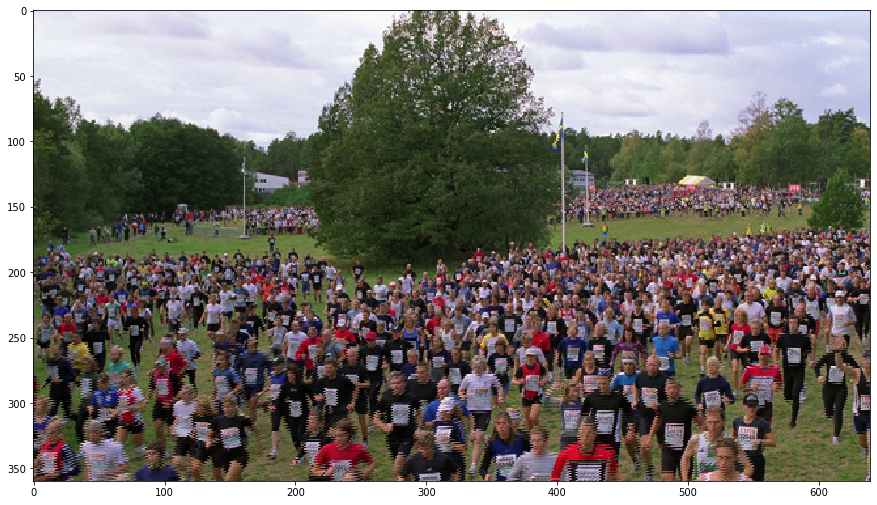

In [6]:
plt.imshow(interlaced[0])

#### 2. Извлекаем последовательные поля из чересстрочного видео:

In [7]:
fields = extract_fields(interlaced)

In [8]:
fields.shape

(100, 180, 640, 3)

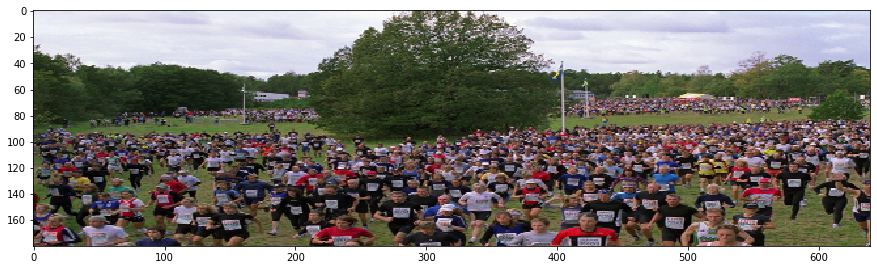

In [9]:
plt.imshow(fields[0])

#### 3. Применяем, наконец, наш алгоритм Bob к последовательным полям:

In [10]:
deinterlaced = deinterlace_bob(fields)

In [11]:
deinterlaced.shape

(100, 360, 640, 3)

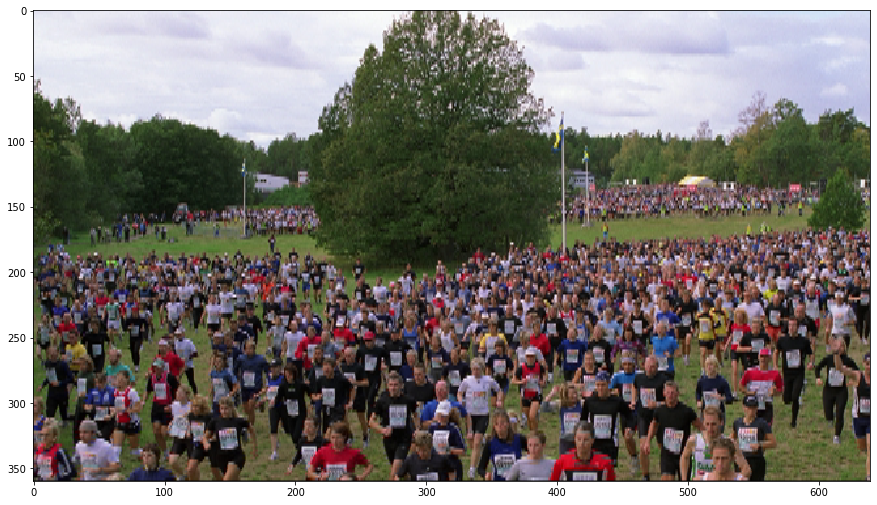

In [32]:
plt.imshow(deinterlaced[2])

### Измерение качества: PSNR, SSIM

* [Peak Signal-to-Noise Ratio (PSNR)](https://en.wikipedia.org/wiki/Structural_similarity)
* [Structural Similarity (SSIM)](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio)

PSNR и SSIM — full-reference метрики. Это означает, что для их измерения необходимо иметь GT (ground-truth, исходные данные). Помимо full-reference бывают no-reference метрики, не требующие GT.

В нашем случае GT — это видео в progressive-развёртке, из которого было получено interlace-видео искусственным образом.

Считываем GT-видео:

In [13]:
gt_video_folder = os.path.join(GT_VIDEO_DIR, '04')
gt_video = read_sequence(gt_video_folder)

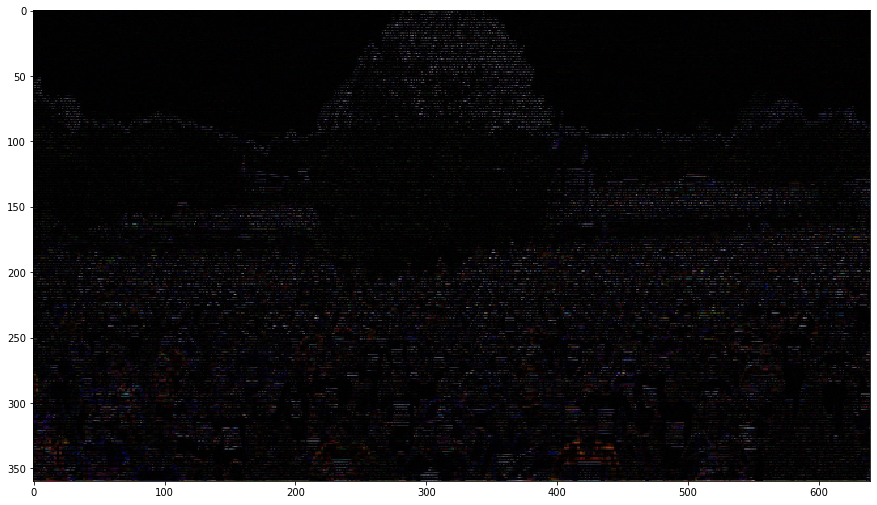

In [14]:
plt.imshow(np.abs(gt_video[0].astype('int16') - deinterlaced[0].astype('int16')))

Вычислим PSNR и SSIM, выдаваемые нашим Bob'ом.

_Замечание_: Вычисление SSIM по целому видео занимает продолжительное время (~10 мин.)

In [15]:
def _psnr(first, second):
    return skimage.metrics.peak_signal_noise_ratio(first, second)

def _ssim(first, second):
    return skimage.metrics.structural_similarity(first, second, multichannel=True)

In [16]:
metrics = {
    'psnr': _psnr,
    'ssim': _ssim
}

metric_values = measure_single(fields, gt_video, deinterlace_bob, metrics)

In [17]:
metric_values

{'psnr': {'mean': 25.956209657097407, 'std': 0.4294135179752883},
 'ssim': {'mean': 0.89644371915808, 'std': 0.0017297162722749075}}

Теперь ваша задача — максимально улучшить этот результат!

In [18]:
fields[0].shape

(180, 640, 3)

### Работа с Optical Flow

Определим вспомогательные функции для интерполяции промежуточного кадра. Для вычисления оптического потока будем пользоваться модулем `cv2`

In [19]:
def warp_image(image, flow, interpolation=cv2.INTER_LANCZOS4):
    mid_flow = -flow / 2
    
    height, width = image.shape[:2]
    map_x = np.ones((height, 1)).dot(np.arange(width).reshape((1, width))) + mid_flow[:,:,0]
    map_y = np.ones((width, 1)).dot(np.arange(height).reshape((1, height))).T + mid_flow[:,:,1]
    
    map_x = map_x.astype(np.float32)
    map_y = map_y.astype(np.float32)
    
    return cv2.remap(image, map_x, map_y, interpolation)

In [225]:
def compute_flow(current_frame, next_frame):
    if next_frame is None:
        return np.zeros((current_frame.shape[0], current_frame.shape[1], 2))
    current_frame = cv2.cvtColor(current_frame.astype('uint8'), cv2.COLOR_RGB2GRAY)
    next_frame = cv2.cvtColor(next_frame.astype('uint8'), cv2.COLOR_RGB2GRAY)
    flow = cv2.calcOpticalFlowFarneback(
        current_frame, next_frame, flow=None, 
        pyr_scale=0.5, levels=5, winsize=15, 
        iterations=5, poly_n=5, poly_sigma=0.5, 
        flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN)
    
    return flow

In [21]:
def interpolate_frames(frames):
    frames = np.array(frames, dtype=np.float32)  # OpenCV может не поддерживать float64
    prev_frame = frames[0]
    interpolated_frames = []
    
    for cur_frame in frames[1:]:
        flow = compute_flow(prev_frame, cur_frame)
        print(prev_frame.shape, cur_frame.shape)
        print(flow.shape)
        intermediate_frame = warp_image(prev_frame, flow.astype(np.float32))
        print(intermediate_frame.shape)
        interpolated_frames.append(intermediate_frame)
        prev_frame = cur_frame
        
    return np.array(interpolated_frames)

Теперь можно пользоваться функцией `interpolate_frames()` для того, чтобы интерполировать поля

In [22]:
interpolated = interpolate_frames(fields[:3:2] / 255.)

(180, 640, 3) (180, 640, 3)
(180, 640, 2)
(180, 640, 3)


In [23]:
image = np.zeros(interlaced.shape[1:], dtype=np.uint8)

In [24]:
image[::2] = np.rint(interpolated[0] * 255.).astype(np.uint8)
image[1::2] = fields[1]
image[:40, :40] = np.array([255, 0, 0])

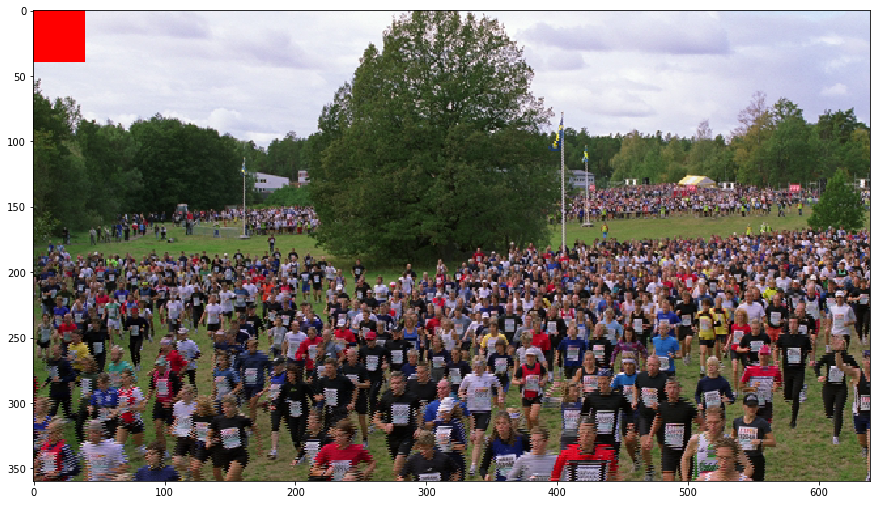

In [25]:
plt.imshow(image)

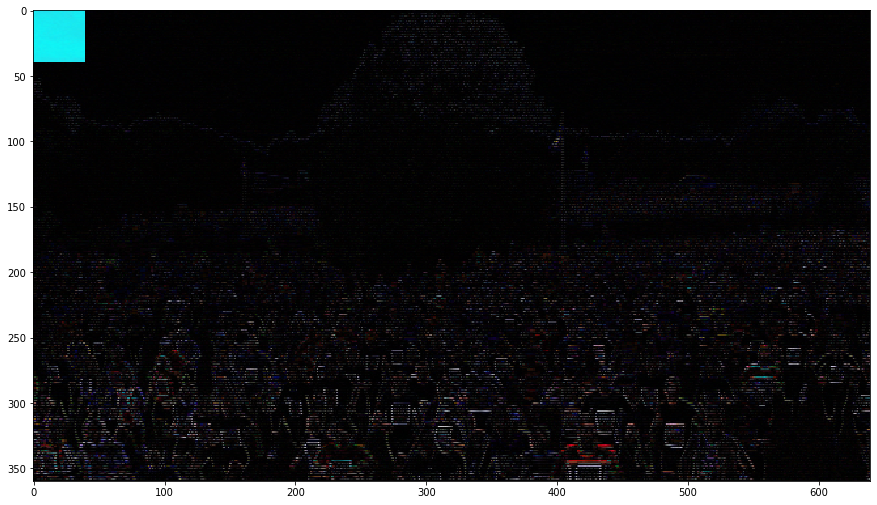

In [26]:
plt.imshow(np.abs(gt_video[1].astype('int16') - image.astype('int16')))

### Your Code

Рекомендуем начать с простого алгоритма, добиться его работоспособности и приемлемого качества, а затем итеративно усложнять модель и подбирать параметры. Не забывайте тестироваться на разных видео из датасета :)

Следующие функции могут оказаться полезными:
* `cv2.calcOpticalFlowFarneback` — вычисляет Optical Flow (подробнее: [док](https://docs.opencv.org/3.4/dc/d6b/group__video__track.html#ga5d10ebbd59fe09c5f650289ec0ece5af), [туториал](https://docs.opencv.org/3.4/d7/d8b/tutorial_py_lucas_kanade.html))

Правила сдачи задания:
 - Комментарий `# GRADED FUNCTION: ...` должен быть первым комментарием в клетке. Его нельзя изменять.
 - Эта клетка должен быть в единственном экземпляре.
 - Оцениваться будет только код, написанный внутри функции `deinterlace_video`.

In [36]:
def laplas(frame):
        blurred = cv2.GaussianBlur(frame, (3, 3), 0)
        gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
        filtered = cv2.Laplacian(gray, cv2.CV_16S, ksize=5)
        return filtered#cv2.convertScaleAbs(filtered)

In [37]:
fields_mas = []
gt_videos = []

for num in tqdm(range(10), leave=False):
    interlaced_video_folder = os.path.join(INTERLACE_VIDEO_DIR, f'0{num}')
    interlaced = read_sequence(interlaced_video_folder)
    fields = extract_fields(interlaced)
    fields_mas.append(fields)
    gt_video_folder = os.path.join(GT_VIDEO_DIR, f'0{num}')
    gt_video = read_sequence(gt_video_folder)
    gt_videos.append(gt_video)

In [38]:
def safe_log(x):
    x[np.where(x == 0)] = 0.001
    return np.log(x)

In [39]:
from scipy.signal import convolve2d
def saliency(field):
    luminance = np.average(field, axis=2, weights=[0.3, 0.59, 0.11])
    four = np.fft.fft2(luminance)
    re = np.real(four)
    imag = np.imag(four)
    Af = np.sqrt(re ** 2 + imag ** 2)
    Pf = np.arctan(imag/re)
    Lf = safe_log(Af)
    hn = np.ones(Lf.shape) / (Lf.shape[0] * Lf.shape[1])
    As = convolve2d(Lf, hn, mode='same')
    Rf = Lf - As
    inv_fourier = np.exp(Pf + Rf) ** 2
    Sx = np.fft.ifft2(inv_fourier)
    Sx = np.real(Sx)
    Sx = np.sqrt(np.abs(Sx))
    Sx = np.sqrt(Sx)
    return cv2.GaussianBlur(Sx, (3, 3), 0)

In [40]:
def interpolate_frame(frame, other_frame):
    flow = compute_flow(other_frame, frame)

    intermediate_frame = warp_image(other_frame, flow.astype(np.float32))

    return intermediate_frame

In [41]:
def bob(block, top_frame_first):
    new_block = []
    if top_frame_first:
        for i in range(1, block.shape[0]):
            new_block.append(block[i]/ 2 + block[i - 1]/2)
        new_block.append(block[block.shape[0] - 1])
    else:
        new_block.append(block[0])
        for i in range(block.shape[0] - 1):
            new_block.append(block[i]/2 + block[i+1]/2)

    return new_block

In [42]:
def merge_blocks(block, other, top_frame_first):
    new_block = np.zeros((block.shape[0]*2, block.shape[1], block.shape[2]))
    #print(other.shape, block.shape)
    if top_frame_first:
        new_block[::2] = block
        new_block[1::2] = other
    else:
        new_block[::2] = other
        new_block[1::2] = block
    return new_block

In [43]:
np.mean(saliency(fields_mas[0][89][0:8:, 0:8]))

21.881565856310797

In [363]:
# GRADED FUNCTION: deinterlace_videox

def deinterlace_video(fields, top_frame_first=True):
    num_frames, height, width, num_channels = fields.shape
    deinterlaced = np.zeros((num_frames, height * 2, width, num_channels), dtype='uint8')

    for index, field in enumerate(tqdm(fields)):
        next_field = fields[index + 1].astype('int16') if index + 1 < len(fields) else None
        next_next_field = fields[index + 2].astype('int16') if index + 2 < len(fields) else None
        prev_field = fields[index - 1].astype('int16') if index - 1 >= 0 else None
        prev_prev_field = fields[index - 2].astype('int16') if index - 2 >= 0 else None
        field = field.astype('int16')
        for row in range(height * 2):
            residual = (row + index) % 2
            field_row = (row - residual) // 2
            prev_field_row = row // 2

            if (top_frame_first and residual == 0) or (not top_frame_first and residual == 1):
                deinterlaced[index, row] = field[field_row]
            else:
                if field_row < 0:
                    # Важно приводить к uint8
                    deinterlaced[index, row] = (field[0] / 2).astype('uint8')
                elif field_row + 1 >= height:
                    deinterlaced[index, row] = (field[-1] / 2).astype('uint8')
                else:
                    # deinterlaced[index, row] = \
                    # np.rint(field[field_row] / 2 + field[field_row + 1] / 2).astype('uint8')

                    c = field[field_row].astype('int16')
                    e = field[field_row + 1].astype('int16')
                    if prev_field is not None and next_field is not None:
                        b = (prev_field[max(0, prev_field_row - 1)].astype('int16') +
                             next_field[max(0, prev_field_row - 1)].astype('int16')) / 2
                        f = (prev_field[min(prev_field_row + 1, prev_field.shape[0] - 1)].astype('int16') +
                             next_field[min(prev_field_row + 1, prev_field.shape[0] - 1)].astype('int16')) / 2
                        d_temp = (prev_field[prev_field_row].astype('int16') +
                                  next_field[prev_field_row].astype('int16')) / 2
                        dT1 = np.abs(prev_field[prev_field_row].astype('int16') -
                                     next_field[prev_field_row].astype('int16'))
                    elif next_field is not None:
                        b = next_field[max(0, prev_field_row - 1)].astype('int16')
                        f = next_field[min(prev_field_row + 1, next_field.shape[0] - 1)].astype('int16')
                        d_temp = next_field[prev_field_row].astype('int16')
                        dT1 = np.zeros((width, num_channels))
                    else:
                        b = prev_field[max(0, prev_field_row - 1)].astype('int16')
                        f = prev_field[min(prev_field_row + 1, prev_field.shape[0] - 1)].astype('int16')
                        d_temp = prev_field[prev_field_row].astype('int16')
                        dT1 = np.zeros((width, num_channels))

                    if prev_prev_field is not None:
                        dT2 = (np.abs(prev_prev_field[field_row].astype('int16') - c) +
                               np.abs(prev_prev_field[field_row + 1].astype('int16') - e)) / 2
                    else:
                        dT2 = np.zeros((width, num_channels))

                    if next_next_field is not None:
                        dT3 = (np.abs(next_next_field[field_row].astype('int16') - c) +
                               np.abs(next_next_field[field_row + 1].astype('int16') - e)) / 2
                    else:
                        dT3 = np.zeros((width, num_channels))

                    dT = np.maximum(2 * dT1, dT2, dT3)

                    dS_min = np.minimum((d_temp - e), (d_temp - c), np.maximum(b - c, f - e))
                    dS_max = np.maximum((d_temp - e), (d_temp - c), np.minimum(b - c, f - e))
                    dS = np.maximum(dS_min, -dS_max)

                    diff = np.maximum(dT, dS)

                    # place for spatial
                    d_spat = (field[field_row].astype('int16') + field[field_row + 1].astype('int16')) / 2

                    spat = np.abs(d_spat - d_temp) <= diff
                    temp_plus = d_spat - d_temp > diff
                    temp_minus = d_spat - d_temp < -diff

                    # print(np.where(temp_plus))
                    for channel in range(num_channels):
                        for x in range(width):
                            if spat[x, channel]:
                                deinterlaced[index, row, x, channel] = np.rint(d_spat[x, channel]).astype('uint8')
                            elif temp_plus[x, channel]:
                                deinterlaced[index, row, x, channel] = np.rint(d_temp[x, channel] +
                                                                               diff[x, channel]).astype('uint8')
                            else:
                                deinterlaced[index, row, x, channel] = np.rint(d_temp[x, channel] -
                                                                               diff[x, channel]).astype('uint8')

    return deinterlaced

Протестируем ваш алгоритм.

In [364]:
metrics = {
    'psnr': _psnr,
    'ssim': _ssim
}

dict_videos = {}
psnr_mean = []
psnr_std = []
ssim_mean = []
ssim_std = []

for num in tqdm(range(10), leave=False):
    metric_values = measure_single(fields_mas[num], gt_videos[num], deinterlace_video, metrics)
    psnr_mean.append(metric_values['psnr']['mean'])
    psnr_std.append(metric_values['psnr']['std'])
    ssim_mean.append(metric_values['ssim']['mean'])
    ssim_std.append(metric_values['ssim']['std'])
    print(num, metric_values)
    dict_videos[f'0{num}'] = metric_values
dict_videos['all'] = {'psnr': {'mean': np.mean(psnr_mean), 'std': np.mean(psnr_std)},
                      'ssim': {'mean': np.mean(ssim_mean), 'std': np.mean(ssim_std)}}
dict_videos


0 {'psnr': {'mean': 28.365916760912288, 'std': 1.8800042485100297}, 'ssim': {'mean': 0.897015206965162, 'std': 0.01778750965923398}}



1 {'psnr': {'mean': 24.89891224928562, 'std': 1.8956530245566148}, 'ssim': {'mean': 0.8917084032832632, 'std': 0.012309640859182434}}



2 {'psnr': {'mean': 29.691633937906207, 'std': 1.5172523177412929}, 'ssim': {'mean': 0.909032761198796, 'std': 0.005314742988480702}}



3 {'psnr': {'mean': 27.131607293403086, 'std': 1.283260192233129}, 'ssim': {'mean': 0.8571962033853333, 'std': 0.024649604405397527}}



4 {'psnr': {'mean': 26.497425705349716, 'std': 0.5040381405844566}, 'ssim': {'mean': 0.9097699281150343, 'std': 0.0054836070129484086}}



5 {'psnr': {'mean': 24.106323385087123, 'std': 0.2959024995644686}, 'ssim': {'mean': 0.7988343850427426, 'std': 0.006582763874615321}}


KeyboardInterrupt: 

In [353]:
num = 4
aq= laplas(gt_videos[num][0])
aq

array([[   48,    48,    56, ...,   -92,   -52,   -16],
       [   48,    34,    14, ...,   -66,   -20,    16],
       [   32,    20,   -20, ...,   -26,    28,    64],
       ...,
       [ 1292,  1234,   952, ..., -1016, -1964, -2084],
       [  624,   348,  -180, ...,  -610,   252,  1204],
       [ -128,  -424,  -872, ...,   -24,  1932,  3432]], dtype=int16)

In [354]:
gray = cv2.cvtColor(fields_mas[num][0], cv2.COLOR_BGR2GRAY)
canny = cv2.Canny(gray, 100, 200)

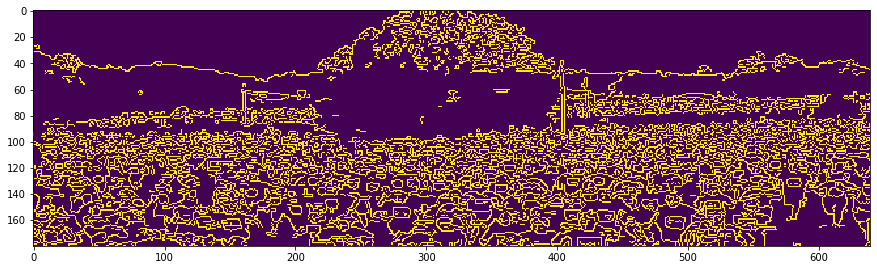

In [355]:
plt.imshow(canny)

In [356]:
canny

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0, 255, 255],
       [255, 255, 255, ..., 255,   0,   0],
       [  0,   0,   0, ..., 255,   0, 255]], dtype=uint8)

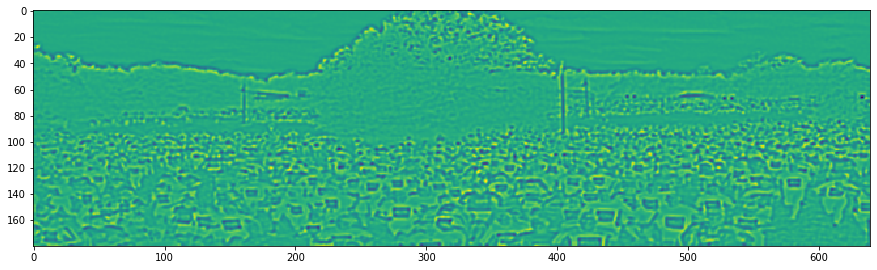

In [357]:
laplased = laplas(fields_mas[num][0])
plt.imshow(laplased)

In [358]:
deinterlaced = deinterlace_video(fields_mas[num])

In [359]:
bobed = deinterlace_bob(fields_mas[num])

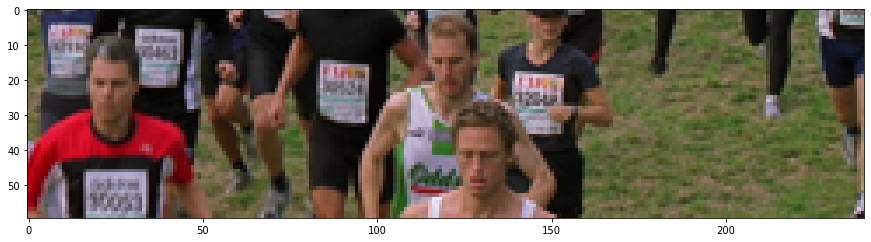

In [360]:
plt.imshow(gt_videos[num][0][300:, 400:])

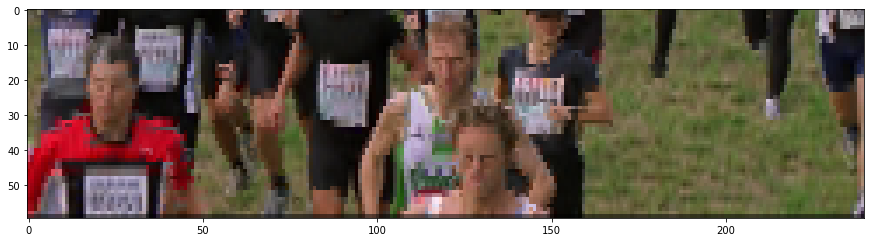

In [361]:
plt.imshow(deinterlaced[0][300:, 400:])

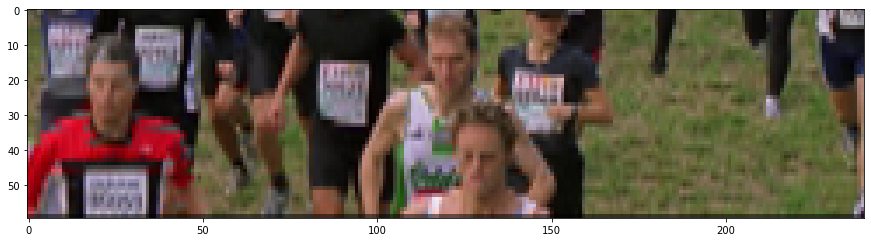

In [362]:
plt.imshow(bobed[0][300:, 400:])

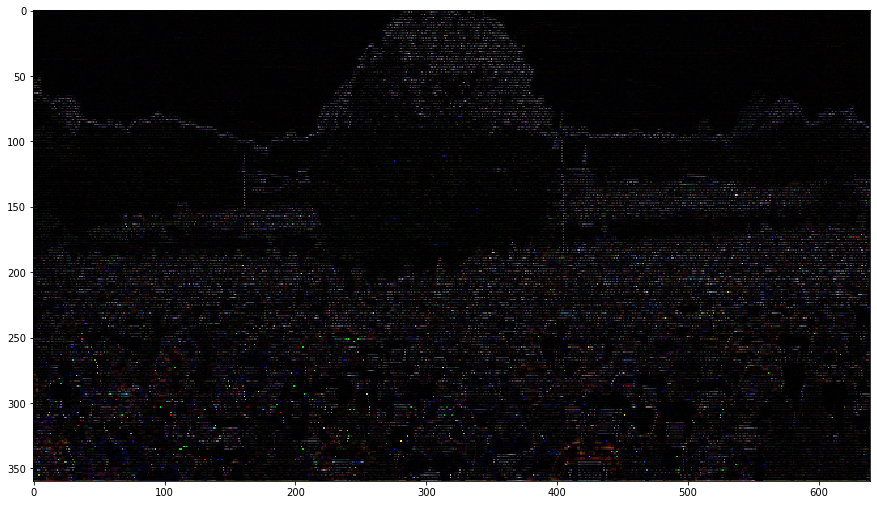

In [266]:
plt.imshow(np.abs(gt_videos[num][0].astype('int16') - deinterlaced[0].astype('int16')))

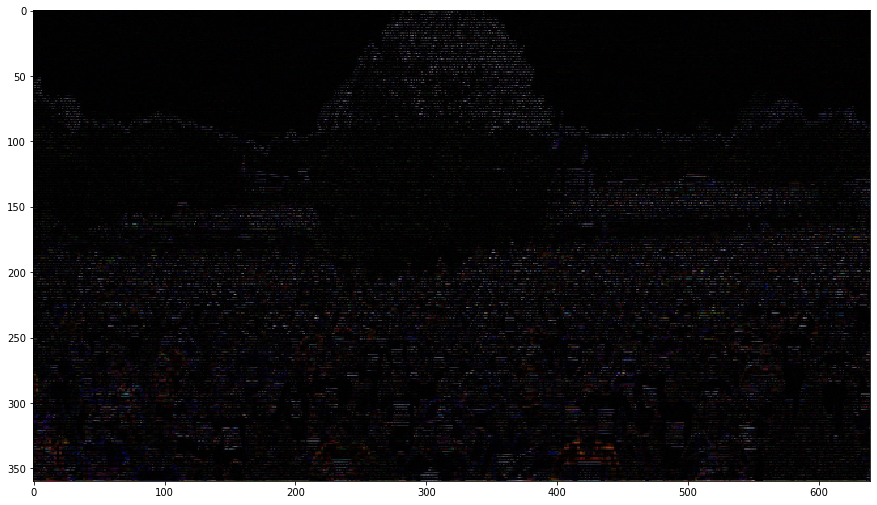

In [199]:
plt.imshow(np.abs(gt_videos[num][0].astype('int16') - deinterlace_bob(fields_mas[num])[0].astype('int16')))

Bob:
{'00': {'psnr': {'mean': 27.152261821822673, 'std': 1.6744812661850579},
  'ssim': {'mean': 0.8736204827395848, 'std': 0.010277961151777317}},
 '01': {'psnr': {'mean': 24.49574619078391, 'std': 1.9427276645168483},
  'ssim': {'mean': 0.8802962111984115, 'std': 0.013615657074392287}},
 '02': {'psnr': {'mean': 29.279849564512936, 'std': 1.5187611781301524},
  'ssim': {'mean': 0.899901910902167, 'std': 0.005658734526762008}},
 '03': {'psnr': {'mean': 26.555625855022235, 'std': 1.4103656997747014},
  'ssim': {'mean': 0.8408813773508668, 'std': 0.030026695490479465}},
 '04': {'psnr': {'mean': 25.956209657097407, 'std': 0.4294135179752883},
  'ssim': {'mean': 0.89644371915808, 'std': 0.0017297162722749075}},
 '05': {'psnr': {'mean': 22.49601290266396, 'std': 0.2741502644306714},
  'ssim': {'mean': 0.7007682373725378, 'std': 0.010709993390478257}},
 '06': {'psnr': {'mean': 30.574875283735523, 'std': 0.31769358462190744},
  'ssim': {'mean': 0.9644608268272796, 'std': 0.0013853347700779452}},
 '07': {'psnr': {'mean': 28.53478179616131, 'std': 0.8867102163729272},
  'ssim': {'mean': 0.8979193973174721, 'std': 0.0018068556538180353}},
 '08': {'psnr': {'mean': 25.855556101043394, 'std': 1.0191316653970406},
  'ssim': {'mean': 0.852677026840814, 'std': 0.01860213860048825}},
 '09': {'psnr': {'mean': 24.35839674032964, 'std': 1.5416152879141678},
  'ssim': {'mean': 0.8115811680762728, 'std': 0.03351410452773673}},
 'all': {'psnr': {'mean': 26.5259315913173, 'std': 1.1015050345318762},
  'ssim': {'mean': 0.8618550357783488, 'std': 0.01273271914582852}}}
  
  fastYadifBob
  {'00': {'psnr': {'mean': 28.025183955007847, 'std': 1.765556367793368},
  'ssim': {'mean': 0.8922434804607206, 'std': 0.015674181422128626}},
 '01': {'psnr': {'mean': 24.872521320493846, 'std': 1.8985973818190174},
  'ssim': {'mean': 0.890896434469236, 'std': 0.012406404890359218}},
 '02': {'psnr': {'mean': 29.604124851249892, 'std': 1.5178848084508432},
  'ssim': {'mean': 0.9073173827582367, 'std': 0.005489614937352075}},
 '03': {'psnr': {'mean': 27.112431800243115, 'std': 1.2863482303384388},
  'ssim': {'mean': 0.8563991846607426, 'std': 0.02485947002761795}},
 '04': {'psnr': {'mean': 26.341294686498603, 'std': 0.4694685793018221},
  'ssim': {'mean': 0.9068803663800519, 'std': 0.005431958555595907}},
 '05': {'psnr': {'mean': 24.005443852709828, 'std': 0.30072099832278626},
  'ssim': {'mean': 0.7932684398086651, 'std': 0.007128660978197945}},
 '06': {'psnr': {'mean': 29.12839567058906, 'std': 0.42635220567623033},
  'ssim': {'mean': 0.9590672222293971, 'std': 0.0035381266578456915}},
 '07': {'psnr': {'mean': 29.99123052980532, 'std': 1.2462866973691316},
  'ssim': {'mean': 0.9324567047367097, 'std': 0.0035790521193859314}},
 '08': {'psnr': {'mean': 25.96407048498128, 'std': 0.9867175212085777},
  'ssim': {'mean': 0.8556216593363856, 'std': 0.01764094739740116}},
 '09': {'psnr': {'mean': 25.068112180264475, 'std': 1.9163922150850436},
  'ssim': {'mean': 0.8344153429227893, 'std': 0.03175190455527354}},
 'all': {'psnr': {'mean': 27.011280933184327, 'std': 1.1814325005365256},
  'ssim': {'mean': 0.8828566217762935, 'std': 0.012750032154115803}}}
  
  YadifBob
  {'00': {'psnr': {'mean': 28.365916760912288, 'std': 1.8800042485100297},
  'ssim': {'mean': 0.897015206965162, 'std': 0.01778750965923398}},
 '01': {'psnr': {'mean': 24.89891224928562, 'std': 1.8956530245566148},
  'ssim': {'mean': 0.8917084032832632, 'std': 0.012309640859182434}},
 '02': {'psnr': {'mean': 29.691633937906207, 'std': 1.5172523177412929},
  'ssim': {'mean': 0.909032761198796, 'std': 0.005314742988480702}},
 '03': {'psnr': {'mean': 27.131607293403086, 'std': 1.283260192233129},
  'ssim': {'mean': 0.8571962033853333, 'std': 0.024649604405397527}},
 '04': {'psnr': {'mean': 26.497425705349716, 'std': 0.5040381405844566},
  'ssim': {'mean': 0.9097699281150343, 'std': 0.0054836070129484086}},
 '05': {'psnr': {'mean': 24.106323385087123, 'std': 0.2959024995644686},
  'ssim': {'mean': 0.7988343850427426, 'std': 0.006582763874615321}},
 '06': {'psnr': {'mean': 30.68117586520114, 'std': 0.530920894717264},
  'ssim': {'mean': 0.9655049795242249, 'std': 0.0033206053567076204}},
 '07': {'psnr': {'mean': 30.046376181101124, 'std': 1.2596720670423718},
  'ssim': {'mean': 0.9338637386221162, 'std': 0.0034596281553473363}},
 '08': {'psnr': {'mean': 26.03628041500312, 'std': 1.0016007016386288},
  'ssim': {'mean': 0.8573159032090377, 'std': 0.017475607667511064}},
 '09': {'psnr': {'mean': 25.195188151241144, 'std': 1.9314026727793303},
  'ssim': {'mean': 0.8368427830371407, 'std': 0.0324830468222477}},
 'all': {'psnr': {'mean': 27.265083994449054, 'std': 1.2099706759367588},
  'ssim': {'mean': 0.8857084292382851, 'std': 0.01288667568016721}}}
  
  Optical flow1
  {'00': {'psnr': {'mean': 26.98972474327065, 'std': 1.6961906173223193},
  'ssim': {'mean': 0.8724282084212105, 'std': 0.010474005223320029}},
 '01': {'psnr': {'mean': 24.221249389346085, 'std': 1.9992190739359674},
  'ssim': {'mean': 0.8775633867228306, 'std': 0.014175180070153254}},
 '02': {'psnr': {'mean': 29.133386640487952, 'std': 1.5211563300684756},
  'ssim': {'mean': 0.8992777181005929, 'std': 0.00578078296840067}},
 '03': {'psnr': {'mean': 26.471511503304228, 'std': 1.4411943894761128},
  'ssim': {'mean': 0.8404058871574432, 'std': 0.030135654437318898}},
 '04': {'psnr': {'mean': 25.876035162518857, 'std': 0.4131162356163036},
  'ssim': {'mean': 0.8957485664393683, 'std': 0.001759391876463193}},
 '05': {'psnr': {'mean': 22.466815509908642, 'std': 0.28983252373324353},
  'ssim': {'mean': 0.7003627626117641, 'std': 0.010844570963542854}},
 '06': {'psnr': {'mean': 30.307542747077047, 'std': 0.36963507554111513},
  'ssim': {'mean': 0.9638073772232029, 'std': 0.001476366437850265}},
 '07': {'psnr': {'mean': 28.454671112806263, 'std': 0.8575374497162835},
  'ssim': {'mean': 0.8970642880331978, 'std': 0.0019177934576188537}},
 '08': {'psnr': {'mean': 25.766716029917788, 'std': 1.0080831914101651},
  'ssim': {'mean': 0.851901883271815, 'std': 0.01866964619603877}},
 '09': {'psnr': {'mean': 24.343043936561713, 'std': 1.5579916772108813},
  'ssim': {'mean': 0.8114601366439139, 'std': 0.03357369357993348}},
 'all': {'psnr': {'mean': 26.40306967751992, 'std': 1.1153956564030865},
  'ssim': {'mean': 0.861002021462534, 'std': 0.012880708521064026}}}

In [ ]:
metric_values = measure_single(fields, gt_video, deinterlace_video, metrics)
metric_values

## В следующей серии...

## Часть 2. Нейросетевой деинтерлейсер

...